<a href="https://colab.research.google.com/github/zjzsu2000/CMPE297_Sec49AdvanceDL/blob/master/Assignment_1/Assignment_1_%20Part_2/semi_supervised_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


#Assignment_1_ Part_2:Semi-supervised Learning 

Jacky Chow (Jie Zou) ID:014545284



##Semi-supervised learning 

supervised learning training data very few labeled examples & large number of unlabeled examples.

- unlabelled data may require use/inspiration unsupervised methods (clustering and density estimation)



##Target 

In this colab, I will illustrate how Semi-supervised learning works through a simple example based on the credit_card_data.

refences:
http://nimbusvault.net/publications/koala/assr/papers/k17is-222.pdf


## Libraries import

In [5]:
import numpy as np
import pandas as pd
import os, time, re
import pickle, gzip


import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
import matplotlib as mpl

%matplotlib inline


from sklearn import preprocessing as pp
from sklearn.model_selection import train_test_split as tts 
from sklearn.model_selection import StratifiedKFold 
from sklearn.metrics import log_loss
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import roc_curve, auc, roc_auc_score


import lightgbm as lgb

import tensorflow as tf
from tensorflow import keras
K = keras.backend

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Activation, Dense, Dropout
from tensorflow.keras.layers import BatchNormalization, Input, Lambda
from tensorflow.keras import regularizers
from tensorflow.keras.losses import mse, binary_crossentropy

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Check


In [6]:
import sys, sklearn
print(f'sklearn    {sklearn.__version__}')
print(f'tensorflow {tf.__version__}')
print(f'keras      {keras.__version__}')
print(f'numpy      {np.__version__}')
print(f'lightgbp   {lgb.__version__}')

sklearn    0.22.2.post1
tensorflow 2.3.0
keras      2.4.0
numpy      1.18.5
lightgbp   2.2.3


In [7]:
tf.random.set_seed(42)
np.random.seed(42)

## Data Preprocessing

### Load the data 

https://www.kaggle.com/mlg-ulb/creditcardfraud

https://www.kaggle.com/general/74235

In [9]:
from google.colab import drive
from google.colab import files
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
pip install kaggle

In [11]:
from google.colab import files

In [12]:
files.upload()

Saving kaggle2.json to kaggle2.json


{'kaggle2.json': b'{"username":"jiezousjsu","key":"f2bcc5cef8cc8372b5bb7914456e0445"}'}

In [13]:
 ! mkdir ~/.kaggle
 ! cp kaggle2.json ~/.kaggle/kaggle.json

In [14]:
 ! chmod 600 ~/.kaggle/kaggle.json

In [15]:
! kaggle datasets list

ref                                                                 title                                                size  lastUpdated          downloadCount  
------------------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  
imoore/60k-stack-overflow-questions-with-quality-rate               60k Stack Overflow Questions with Quality Rating     21MB  2020-09-08 09:26:05            550  
ihelon/lego-minifigures-classification                              LEGO Minifigures Classification                      12MB  2020-09-08 16:48:53            598  
anikannal/solar-power-generation-data                               Solar Power Generation Data                           2MB  2020-08-18 15:52:03           2512  
douglaskgaraujo/opportunity-insights-real-time-economic-tracker-us  Opportunity Insights real time Economic Tracker US   22MB  2020-09-07 18:23:07            242  
ruchi798/bookcro

In [16]:
!kaggle datasets download -d mlg-ulb/creditcardfraud

 99% 65.0M/66.0M [00:02<00:00, 21.8MB/s]
100% 66.0M/66.0M [00:02<00:00, 27.4MB/s]


In [17]:
! mkdir data_credit_card

In [18]:
! unzip creditcardfraud.zip -d data_credit_card

Archive:  creditcardfraud.zip
  inflating: data_credit_card/creditcard.csv  


In [ ]:
ls

In [20]:
data_raw = pd.read_csv('data_credit_card/creditcard.csv')

In [21]:
data_raw.head(3)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0


In [22]:
data_X = data_raw.copy().drop(['Class','Time'],axis=1)
data_Y = data_raw['Class'].copy()

### StandardScale

In [24]:
featuresToScale = data_X.columns
X_std = pp.StandardScaler(copy=True, with_mean=True, with_std=True)

In [25]:
data_X.loc[:,featuresToScale] = X_std.fit_transform(data_X[featuresToScale])

### Split train and test dataset

In [26]:
X_train, X_test, y_train, y_test = tts(data_X, data_Y, test_size=0.3, random_state=2018, stratify=data_Y)

In [27]:
X_train.shape

(199364, 29)

In [28]:
y_train.shape

(199364,)

In [29]:
np.sum(y_train==0)

199020

In [30]:
np.sum(y_train==1)

344

### Drop the labels from the training set to get some unlable data

In [31]:
toDrop = y_train[y_train==1].sample(frac=0.90,random_state=2018)


In [32]:
X_train.drop(labels=toDrop.index,inplace=True)
y_train.drop(labels=toDrop.index,inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


after drop 90%

In [33]:
np.sum(y_train==0)

199020

In [34]:
np.sum(y_train==1)

34

### evaluation function 

In [35]:
def a_scores(originalDF, reducedDF):
    loss = np.sum((np.array(originalDF) - 
                   np.array(reducedDF))**2, axis=1)
    loss = pd.Series(data=loss,index=originalDF.index)
    loss = (loss-np.min(loss))/(np.max(loss)-np.min(loss))
    return loss

## function to assess precision at a given recall threshold

In [36]:
def precisionAnalysis(df, column, threshold):
    df.sort_values(by=column, ascending=False, inplace=True)
    threshold_value = threshold*df.trueLabel.sum()
    i = 0
    j = 0
    while i < threshold_value+1:
        if df.iloc[j]["trueLabel"]==1:
            i += 1
        j += 1
    return df, i/j

## Supervised Model 

In [37]:
k_fold = StratifiedKFold(n_splits=5,shuffle=True,random_state=2018)

In [38]:
params = {  'task': 'train',    'application':'binary',
    'num_class':1,    'boosting': 'gbdt',    'objective': 'binary',
    'metric': 'binary_logloss',  'metric_freq':50,  'is_training_metric':False,
    'max_depth':4,    'num_leaves': 31,    'learning_rate': 0.01,
    'feature_fraction': 1.0,    'bagging_fraction': 1.0,  'bagging_freq': 0,
    'bagging_seed': 2018,    'verbose': 0,    'num_threads':16}

In [40]:
trainingScores = []
cvScores = []
predictionsBasedOnKFolds = pd.DataFrame(data=[], index=y_train.index, 
                                        columns=['prediction'])

for train_index, cv_index in k_fold.split(np.zeros(len(X_train)), 
                                          y_train.ravel()):
    X_train_fold, X_cv_fold = X_train.iloc[train_index,:], X_train.iloc[cv_index,:]
    y_train_fold, y_cv_fold = y_train.iloc[train_index],   y_train.iloc[cv_index]
    
    lgb_train = lgb.Dataset(X_train_fold, y_train_fold)
    lgb_eval = lgb.Dataset(X_cv_fold, y_cv_fold, reference=lgb_train)
    gbm = lgb.train(params, lgb_train, num_boost_round=2000,
                   valid_sets=lgb_eval, early_stopping_rounds=200)
    
    loglossTraining = log_loss(y_train_fold, gbm.predict(X_train_fold, 
                                num_iteration=gbm.best_iteration))
    trainingScores.append(loglossTraining)
    
    predictionsBasedOnKFolds.loc[X_cv_fold.index,'prediction'] = gbm.predict(
        X_cv_fold, num_iteration=gbm.best_iteration) 
    loglossCV = log_loss(y_cv_fold, predictionsBasedOnKFolds.loc[X_cv_fold.index,'prediction'])
    cvScores.append(loglossCV)
    
    print(f'Training Log Loss: {loglossTraining}')
    print(f'CV Log Loss: {loglossCV}')

[1]	valid_0's binary_logloss: 0.00321986
Training until validation scores don't improve for 200 rounds.
[2]	valid_0's binary_logloss: 0.00317819
[3]	valid_0's binary_logloss: 0.00255191
[4]	valid_0's binary_logloss: 0.0028994
[5]	valid_0's binary_logloss: 0.00201755
[6]	valid_0's binary_logloss: 0.0020024
[7]	valid_0's binary_logloss: 0.00198964
[8]	valid_0's binary_logloss: 0.00197891
[9]	valid_0's binary_logloss: 0.00196711
[10]	valid_0's binary_logloss: 0.0019539
[11]	valid_0's binary_logloss: 0.00194175
[12]	valid_0's binary_logloss: 0.00192937
[13]	valid_0's binary_logloss: 0.001918
[14]	valid_0's binary_logloss: 0.00190637
[15]	valid_0's binary_logloss: 0.00189581
[16]	valid_0's binary_logloss: 0.00188551
[17]	valid_0's binary_logloss: 0.00187701
[18]	valid_0's binary_logloss: 0.00186782
[19]	valid_0's binary_logloss: 0.0018573
[20]	valid_0's binary_logloss: 0.00184705
[21]	valid_0's binary_logloss: 0.00183708
[22]	valid_0's binary_logloss: 0.00182733
[23]	valid_0's binary_loglos

In [41]:
log_loss_Gradient_Boosting = log_loss(y_train, predictionsBasedOnKFolds.loc[:,'prediction'])
print(f'Gradient Boosting Log Loss: {round(log_loss_Gradient_Boosting,4)}')

Gradient Boosting Log Loss: 0.0017


In [42]:
def plot_results(trueLabels, anomalyScores, returnPreds = False):
    preds = pd.concat([trueLabels, anomalyScores], axis=1)
    preds.columns = ['trueLabel', 'anomalyScore']
    precision, recall, thresholds = \
        precision_recall_curve(preds['trueLabel'], 
                               preds['anomalyScore'])
    average_precision = average_precision_score( 
                        preds['trueLabel'], preds['anomalyScore'])
    
    plt.step(recall, precision, color='k', alpha=0.7, where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.3, color='k')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    
    plt.title('Precision-Recall curve: Average Precision = \
        {0:0.2f}'.format(average_precision))

    fpr, tpr, thresholds = roc_curve(preds['trueLabel'], 
                                     preds['anomalyScore'])
    areaUnderROC = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='r', lw=2, label='ROC curve')
    plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic: Area under the \
        curve = {0:0.2f}'.format(areaUnderROC))
    plt.legend(loc="lower right")
    plt.show()
    
    if returnPreds==True:
        return preds, average_precision

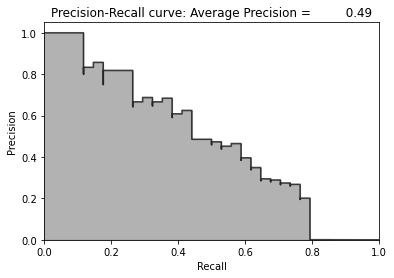

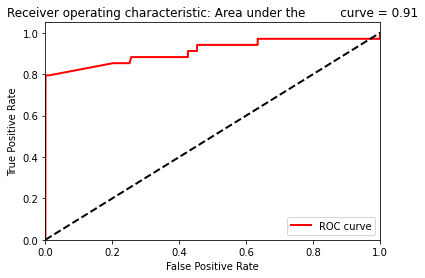

In [43]:
preds, average_precision = plot_results(y_train, predictionsBasedOnKFolds.loc[:,'prediction'], True)

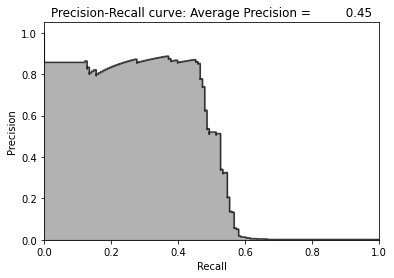

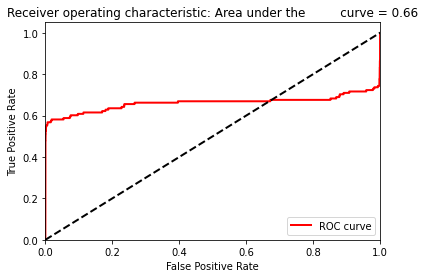

In [44]:
predictions = pd.Series(data=gbm.predict(X_test, num_iteration=gbm.best_iteration), index=X_test.index)
preds, average_precision = plot_results(y_test, predictions, True)

In [45]:
preds, precision = precisionAnalysis(preds, "anomalyScore", 0.75)
print(f'Precision at 75% recall {round(precision,4)}')

Precision at 75% recall 0.0013


## Unsupervised Model

#### Take the 34 fraudulent cases / 100 times

In [46]:
oversample_multiplier = 100

X_train_original = X_train.copy()
y_train_original = y_train.copy()
X_test_original = X_test.copy()
y_test_original = y_test.copy()

X_train_oversampled = X_train.copy()
y_train_oversampled = y_train.copy()
X_train_oversampled = X_train_oversampled.append( \
        [X_train_oversampled[y_train==1]]*oversample_multiplier, \
        ignore_index=False)
y_train_oversampled = y_train_oversampled.append( \
        [y_train_oversampled[y_train==1]]*oversample_multiplier, \
        ignore_index=False)

X_train = X_train_oversampled.copy()
y_train = y_train_oversampled.copy()

In [47]:
X_train.shape, y_train.shape

((202454, 29), (202454,))

A sparse two-layer overcomplete autoencoder with a linear a linear activation function.  
Forty nodes in the hidden layer and a dropout of 2%

In [48]:
model = Sequential()
model.add(Dense(units=40, activation='linear', activity_regularizer=regularizers.l1(1e-4),
                input_dim=29, name='hidden_layer'))
model.add(Dropout(0.02))
model.add(Dense(units=29, activation='linear'))

In [49]:
!pip install pyyaml h5py
import os, datetime
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint as mcp
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = TensorBoard(logdir, histogram_freq=1)

In [50]:
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

In [51]:
run_eagerly = EarlyStopping(monitor='loss', min_delta=0, patience=20, verbose=1, mode='auto')
callbacks_list = [run_eagerly,tensorboard_callback]

In [52]:
num_epochs =  5
batch_size = 32

history = model.fit(x=X_train, y=X_train, epochs=num_epochs, batch_size=batch_size, shuffle=True,validation_split=0.20, verbose=1,callbacks=tensorboard_callback)

Epoch 1/5
   1/5062 [..............................] - ETA: 2s - loss: 1.3463 - accuracy: 0.0938WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
5062/5062 [==============================] - 17s 3ms/step - loss: 0.0726 - accuracy: 0.8684 - val_loss: 0.0127 - val_accuracy: 0.9790
Epoch 2/5
5062/5062 [==============================] - 17s 3ms/step - loss: 0.0179 - accuracy: 0.9259 - val_loss: 0.0210 - val_accuracy: 0.9820
Epoch 3/5
5062/5062 [==============================] - 16s 3ms/step - loss: 0.0171 - accuracy: 0.9260 - val_loss: 0.3741 - val_accuracy: 0.9569
Epoch 4/5
5062/5062 [==============================] - 17s 3ms/step - loss: 0.0174 - accuracy: 0.9276 - val_loss: 0.0410 - val_accuracy: 0.9659
Epoch 5/5
5062/5062 [==============================] - 17s 3

In [53]:
model.save('model1_trained_1.hdf5')

In [54]:
num_epochs2 = 100
batch_size2 = 64

history2 = model.fit(x=X_train, y=X_train, epochs=num_epochs2, batch_size=batch_size2, shuffle=True,validation_split=0.20, verbose=1,callbacks=callbacks_list)

Epoch 1/100
2531/2531 [==============================] - 9s 3ms/step - loss: 0.0166 - accuracy: 0.9296 - val_loss: 0.0056 - val_accuracy: 0.9875
Epoch 2/100
2531/2531 [==============================] - 9s 3ms/step - loss: 0.0163 - accuracy: 0.9298 - val_loss: 0.0209 - val_accuracy: 0.9674
Epoch 3/100
2531/2531 [==============================] - 9s 3ms/step - loss: 0.0164 - accuracy: 0.9289 - val_loss: 0.0215 - val_accuracy: 0.9837
Epoch 4/100
2531/2531 [==============================] - 8s 3ms/step - loss: 0.0165 - accuracy: 0.9287 - val_loss: 0.0123 - val_accuracy: 0.9740
Epoch 5/100
2531/2531 [==============================] - 9s 3ms/step - loss: 0.0163 - accuracy: 0.9284 - val_loss: 0.0262 - val_accuracy: 0.9759
Epoch 6/100
2531/2531 [==============================] - 9s 3ms/step - loss: 0.0159 - accuracy: 0.9294 - val_loss: 0.0074 - val_accuracy: 0.9883
Epoch 7/100
2531/2531 [==============================] - 9s 3ms/step - loss: 0.0168 - accuracy: 0.9289 - val_loss: 0.0075 - val_ac

In [ ]:
def plot_accuracy(history,title):
    plt.title(title)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train_accuracy', 'validation_accuracy'], loc='best')
    plt.show()

    
def plot_loss(history,title):
    plt.title(title)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train_loss', 'validation_loss'], loc='best')
    plt.show()

In [55]:
model.save('model1_trained_2.hdf5')

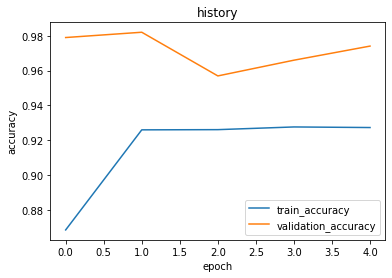

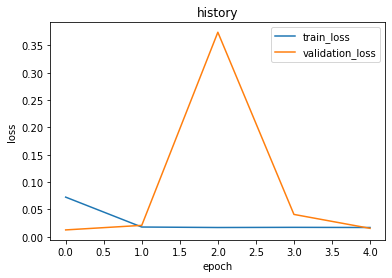

In [56]:
plot_accuracy(history,'history')
plot_loss(history,'history')

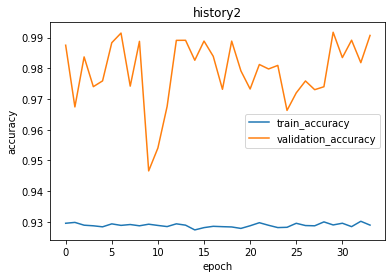

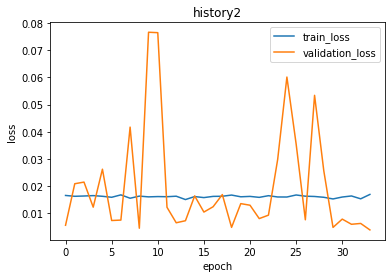

In [57]:
plot_accuracy(history2,'history2')
plot_loss(history2,'history2')

6221/6221 [==============================] - 6s 1ms/step


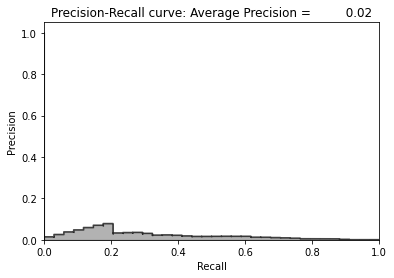

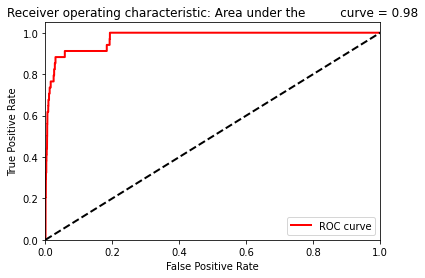

In [61]:
predictionsTrain = model.predict(X_train_original, verbose=1)
anomalyScoresAETrain = a_scores(X_train_original, predictionsTrain)
preds, average_precision = plot_results(y_train_original, anomalyScoresAETrain, True)

2671/2671 [==============================] - 3s 1ms/step


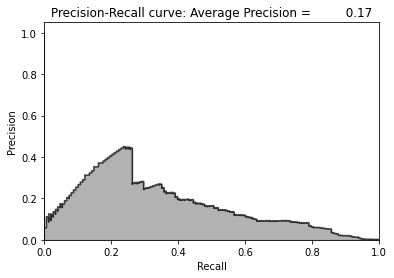

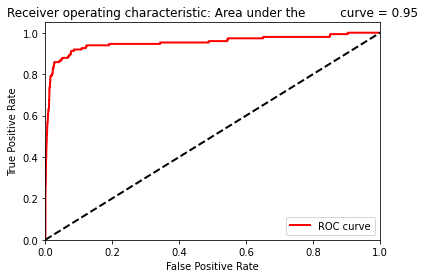

In [62]:
predictions = model.predict(X_test, verbose=1)
anomalyScoresAE = a_scores(X_test, predictions)
preds, average_precision = plot_results(y_test, anomalyScoresAE, True)

In [64]:
preds, precision = precisionAnalysis(preds, "anomalyScore", 0.75)
print(f'Precision at 75% recall {round(precision,4)}')

Precision at 75% recall 0.0859


## Semisupervised Model

In [65]:
layer_name = 'hidden_layer'

intermediate_layer_model  = Model(inputs=model.input, outputs=model.get_layer(layer_name).output)
intermediate_output_train = intermediate_layer_model.predict(X_train_original)
intermediate_output_test  = intermediate_layer_model.predict(X_test_original)

In [66]:
intermediate_output_trainDF = pd.DataFrame(data=intermediate_output_train,index=X_train_original.index)
intermediate_output_testDF  = pd.DataFrame(data=intermediate_output_test,index=X_test_original.index)

In [67]:
X_train = X_train_original.merge(intermediate_output_trainDF, left_index=True,right_index=True)
X_test  = X_test_original.merge(intermediate_output_testDF, left_index=True,right_index=True)
y_train = y_train_original.copy()

In [70]:
trainingScores = []
cvScores = []
predictionsBasedOnKFolds = pd.DataFrame(data=[],index=y_train.index,  columns=['prediction'])

for train_index, cv_index in k_fold.split(np.zeros(len(X_train)), y_train.ravel()):
    X_train_fold, X_cv_fold = X_train.iloc[train_index,:], X_train.iloc[cv_index,:]
    y_train_fold, y_cv_fold = y_train.iloc[train_index], y_train.iloc[cv_index]
    
    lgb_train = lgb.Dataset(X_train_fold, y_train_fold)
    lgb_eval = lgb.Dataset(X_cv_fold, y_cv_fold, reference=lgb_train)
    gbm = lgb.train(params, lgb_train, num_boost_round=5000,
                   valid_sets=lgb_eval, early_stopping_rounds=200)
    
    loglossTraining = log_loss(y_train_fold, gbm.predict(X_train_fold,num_iteration=gbm.best_iteration))
    trainingScores.append(loglossTraining)
    
    predictionsBasedOnKFolds.loc[X_cv_fold.index,'prediction'] = gbm.predict(X_cv_fold, num_iteration=gbm.best_iteration) 
    loglossCV = log_loss(y_cv_fold, predictionsBasedOnKFolds.loc[X_cv_fold.index,'prediction'])
    cvScores.append(loglossCV)
    
    print(f'Training Log Loss: {round(loglossTraining,4)}')
    print(f'CV Log Loss: {round(loglossCV,4)}' )

[1]	valid_0's binary_logloss: 0.00327025
Training until validation scores don't improve for 200 rounds.
[2]	valid_0's binary_logloss: 0.00290997
[3]	valid_0's binary_logloss: 0.00284211
[4]	valid_0's binary_logloss: 0.00277689
[5]	valid_0's binary_logloss: 0.0027309
[6]	valid_0's binary_logloss: 0.00268727
[7]	valid_0's binary_logloss: 0.0026499
[8]	valid_0's binary_logloss: 0.00261396
[9]	valid_0's binary_logloss: 0.00257594
[10]	valid_0's binary_logloss: 0.00254678
[11]	valid_0's binary_logloss: 0.00252072
[12]	valid_0's binary_logloss: 0.00249375
[13]	valid_0's binary_logloss: 0.00247227
[14]	valid_0's binary_logloss: 0.00245253
[15]	valid_0's binary_logloss: 0.00243425
[16]	valid_0's binary_logloss: 0.00241724
[17]	valid_0's binary_logloss: 0.00240134
[18]	valid_0's binary_logloss: 0.00238647
[19]	valid_0's binary_logloss: 0.0023724
[20]	valid_0's binary_logloss: 0.00235913
[21]	valid_0's binary_logloss: 0.00234751
[22]	valid_0's binary_logloss: 0.00233551
[23]	valid_0's binary_log

In [71]:
loglossLightGBMGradientBoosting = log_loss(y_train, predictionsBasedOnKFolds.loc[:,'prediction'])
print(f'LightGBM Gradient Boosting Log Loss: {round(loglossLightGBMGradientBoosting,4)}')

LightGBM Gradient Boosting Log Loss: 0.002


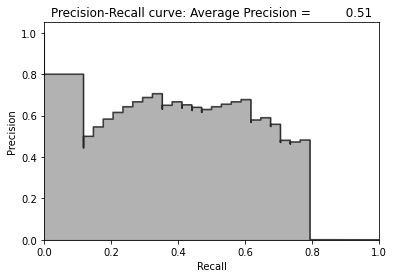

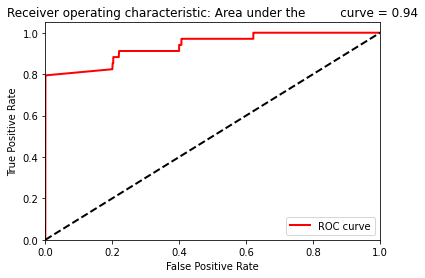

In [73]:
preds, average_precision = plot_results(y_train, predictionsBasedOnKFolds.loc[:,'prediction'], True)

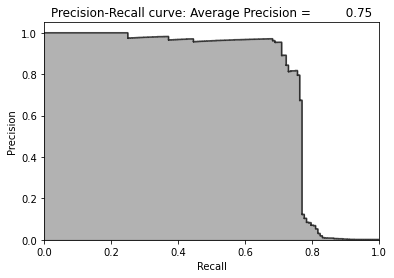

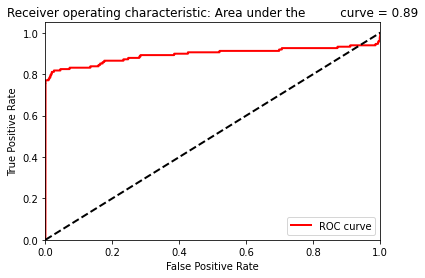

In [74]:
predictions = pd.Series(data=gbm.predict(X_test, num_iteration=gbm.best_iteration),index=X_test.index)
preds, average_precision = plot_results(y_test, predictions, True)

In [75]:
preds, precision = precisionAnalysis(preds, "anomalyScore", 0.75)
print(f'{round(precision,4)}')

0.8175


In [85]:
features_importance = pd.DataFrame(data=list(gbm.feature_importance()), index=X_train.columns,columns=['importance'])
features_importance = featuresImportance/featuresImportance.sum()
features_importance.sort_values(by='featImportance', ascending=False,inplace=True)
features_importance

,featImportance
Amount,0.068303
17,0.064376
V14,0.048016
V11,0.046380
14,0.045317
...,...
26,0.001063
29,0.000982
V23,0.000982
18,0.000818


In [ ]:
!tensorboard dev upload --logdir ./logs --name "Assignment1_part2 TensorBoard"

2020-09-10 05:53:23.996112: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1

***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./logs

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=373649185512-8v619h5kft38l4456nm2dj4ubeqsrvh6.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&sc